In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import matplotlib
import random as rd
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

In [3]:
datelist = pd.date_range(start='29/06/2023 00:00:00', end='29/07/2023', freq='H').to_series()
datelist.index = datelist
datelist['29/06/2023 00:00:00'] = 5000.0
datelist['29/06/2023 01:00:00'] = 5015.0

In [4]:
def fun(X, alp: float, beta: float, max_kf: float, trend: float, season: float):
    j = 2
    k = 2
    for i in X[2:]:
        X[i] = (alp * X[i-dt.timedelta(1/24)] + beta * X[i-dt.timedelta(2/24)]) + rd.uniform(-max_kf, max_kf) + trend * j
        if k%(7*24)==0:
            X[i]+=season
        if k%(7*24)==1:
            X[i]-=season
        k+=1
    return X

<AxesSubplot:>

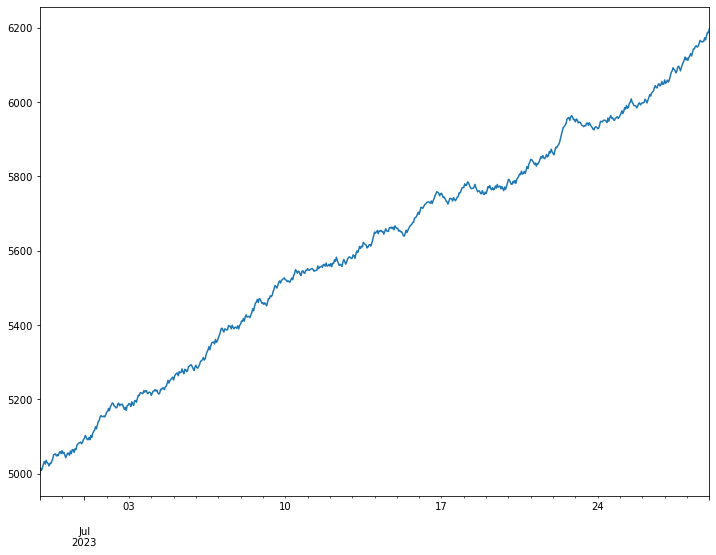

In [5]:
first_ts = fun(datelist.copy(), 0.9, 0.1, 10, 1, 0)
first_ts.plot(figsize=(12,9))

<AxesSubplot:>

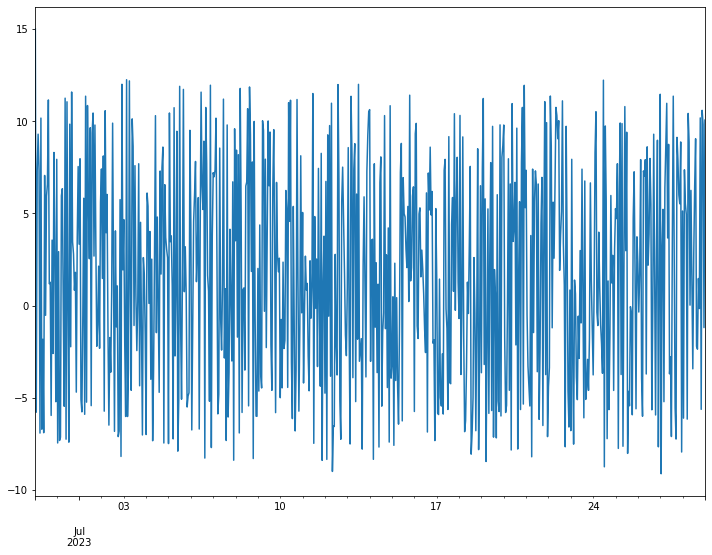

In [6]:
first_diff = first_ts.diff(periods=1).dropna()
first_diff.plot(figsize=(12,9))

In [7]:
test = sm.tsa.adfuller(first_diff)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -31.398637737504096
p-value:  0.0
Critical values:  {'1%': -3.439477677285233, '5%': -2.865568186630048, '10%': -2.5689150720653977}
единичных корней нет, ряд стационарен


In [8]:
m = first_diff.index[int(len(first_diff.index)/2+1)]
r1 = sm.stats.DescrStatsW(first_diff[m:])
r2 = sm.stats.DescrStatsW(first_diff[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.5459733975958405


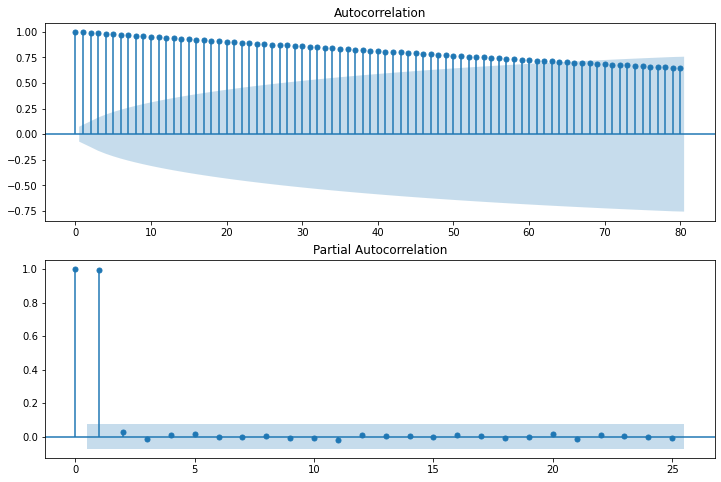

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_ts.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_ts, lags=25, ax=ax2)

In [10]:
src_data_model = first_ts[:'2023-07-17 00:00:00']
src_data_model

2023-06-29 00:00:00         5000.0
2023-06-29 01:00:00         5015.0
2023-06-29 02:00:00     5009.20981
2023-06-29 03:00:00     5016.51545
2023-06-29 04:00:00    5025.809014
                          ...     
2023-07-16 20:00:00    5757.206812
2023-07-16 21:00:00    5755.352317
2023-07-16 22:00:00    5748.024571
2023-07-16 23:00:00    5753.283231
2023-07-17 00:00:00    5754.873313
Length: 433, dtype: object

In [11]:
model = sm.tsa.ARIMA(src_data_model.astype(float), order=(1,1,1)).fit()
#full_output=False, disp=0

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  war

In [12]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  432
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1369.843
Method:                       css-mle   S.D. of innovations              5.766
Date:                Thu, 28 Sep 2023   AIC                           2747.686
Time:                        17:35:21   BIC                           2763.960
Sample:                    06-29-2023   HQIC                          2754.111
                         - 07-17-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7418      0.224      7.759      0.000       1.302       2.182
ar.L1.D.y     -0.0844      0.210     -0.401      0.688      -0.497       0.328
ma.L1.D.y     -0.1229      0.208     -0.590      0.5

In [13]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.000797  0.977473
1    0.002453  0.998774
2    0.327798  0.954718
3    0.343301  0.986850
4    0.385784  0.995712
5    0.568714  0.996899
6    0.572945  0.999133
7    1.407672  0.994137
8    2.391913  0.983650
9    2.393726  0.992336
10   4.023408  0.969227
11   4.135910  0.980857
12   5.548934  0.961042
13   7.163013  0.928245
14   7.864195  0.929112
15   7.866749  0.952735
16   8.364844  0.958111
17   9.706610  0.941063
18  11.802118  0.893908
19  13.523690  0.853802
20  14.135883  0.863692
21  14.147253  0.896171
22  15.126823  0.890031
23  15.481508  0.905876
24  16.146312  0.910402
25  18.265932  0.865885
26  18.359641  0.892144
27  18.382946  0.916091
28  21.019317  0.858445
29  21.643625  0.866690
30  21.692156  0.892445
31  22.312128  0.898833
32  23.356208  0.893106
33  23.359753  0.915164
34  23.505376  0.930522
35  23.865038  0.939584
36  25.947754  0.913292
37  25.985728  0.930450
38  27.218101  0.922322
39  28.033178  0.922815


D:\Programs\Anac\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [14]:
pred = model.predict('2023-07-17 00:00:00','2023-07-29 00:00:00', typ='levels')
trn = first_ts['2023-07-17 00:00:00':]
r2 = r2_score(trn, pred)
print ('R^2: %1.2f' % r2)

R^2: 0.47


D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [15]:
mean_squared_error(trn,pred, squared=False)

93.82575600376545

In [16]:
metrics.mean_absolute_error(trn,pred)

88.62182184327982

In [18]:
mean_absolute_percentage_error(trn, pred)

0.014932593908954576

In [19]:
for i in first_ts:
    if type(i) != float:
        print(i)

<AxesSubplot:>

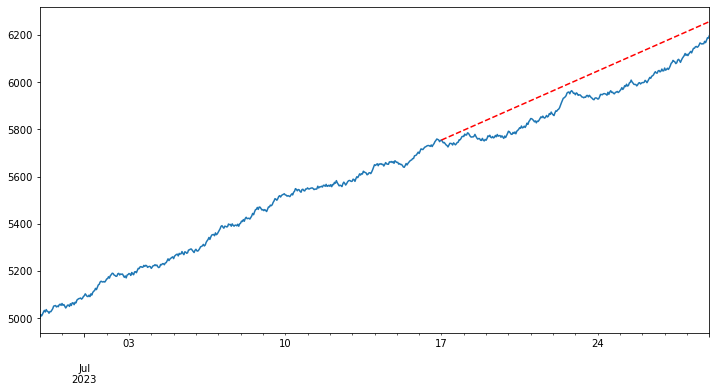

In [20]:
first_ts.plot(figsize=(12,6))
pred.plot(style='r--')

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

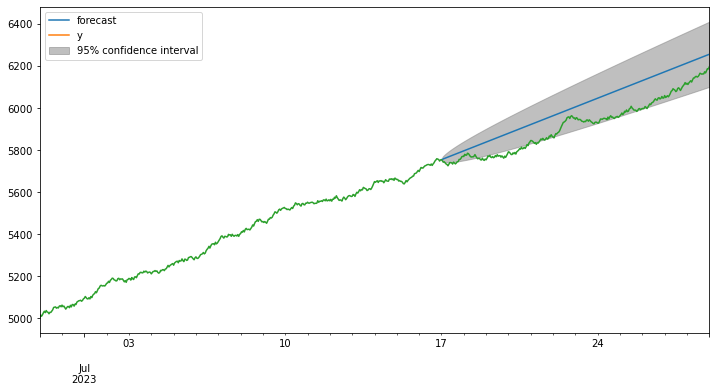

In [23]:
model.plot_predict('2023-07-17 00:00:00','2023-07-29 00:00:00')
first_ts.plot(figsize=(12,6))

In [24]:
for i in first_ts:
    if type(i) != float:
        print(i)

In [26]:
history = src_data_model.copy()
predictions1 = list()

date = pd.date_range('2023-07-17 00:00:00','2023-07-29 00:00:00', freq = "H").to_list()
for t in range(len(date)):
    model = sm.tsa.ARIMA(history.astype(float), order=(1,1,1))
    model_fit = model.fit(freq=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    #print(yhat)
    predictions1.append(yhat)
    #obs = test[t]
    history[date[t]] = yhat
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
#rmse = math.sqrt(mean_squared_error(test, predictions))
#print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  war

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H w

<AxesSubplot:>

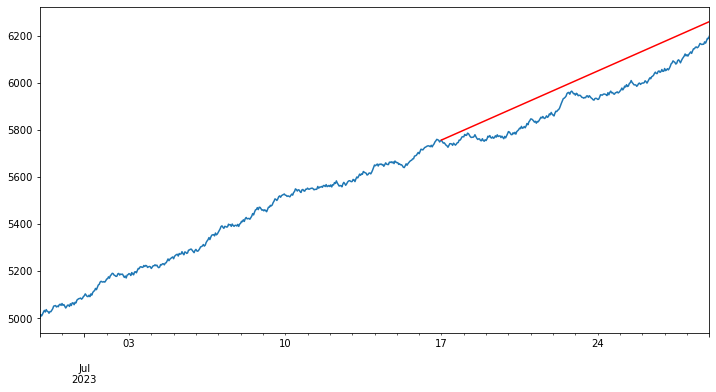

In [27]:
first_ts.plot(figsize=(12,6))
predictions1 = pd.Series(predictions1, index = date)
predictions1.plot(color='red')

In [28]:
for i in first_ts:
    if type(i) != float:
        print(i)

In [29]:
first_ts['2023-07-17 00:00:00':].head()

2023-07-17 00:00:00    5754.873313
2023-07-17 01:00:00    5749.031681
2023-07-17 02:00:00    5743.117345
2023-07-17 03:00:00    5744.549203
2023-07-17 04:00:00    5739.557524
dtype: object

<AxesSubplot:>

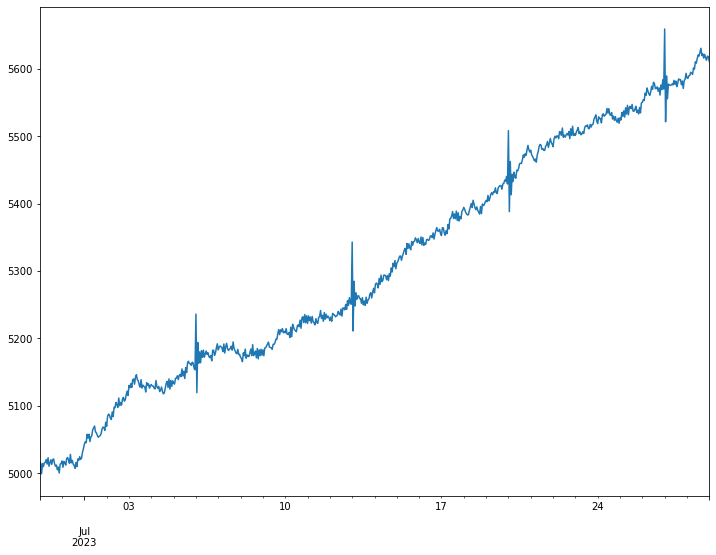

In [30]:
second_ts = fun(datelist.copy(), 0.4501, 0.5483, 10, 5, 80)
second_ts.plot(figsize=(12,9))

<AxesSubplot:>

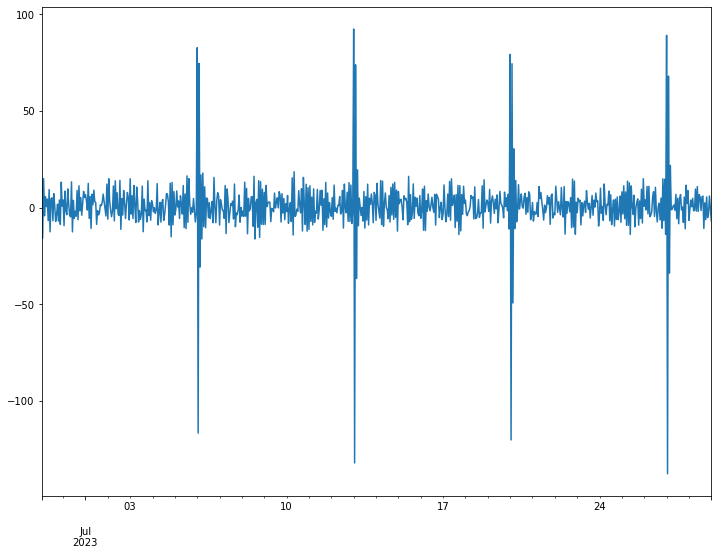

In [31]:
second_diff = second_ts.diff(periods=1).dropna()
second_diff.plot(figsize=(12,9))

In [32]:
test = sm.tsa.adfuller(second_diff)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -18.60150058106498
p-value:  2.069020748937701e-30
Critical values:  {'1%': -3.439516060164992, '5%': -2.8655850998755263, '10%': -2.5689240826597173}
единичных корней нет, ряд стационарен


In [33]:
m = second_diff.index[int(len(second_diff.index)/2+1)]
r1 = sm.stats.DescrStatsW(second_diff[m:])
r2 = sm.stats.DescrStatsW(second_diff[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.8978947725282064


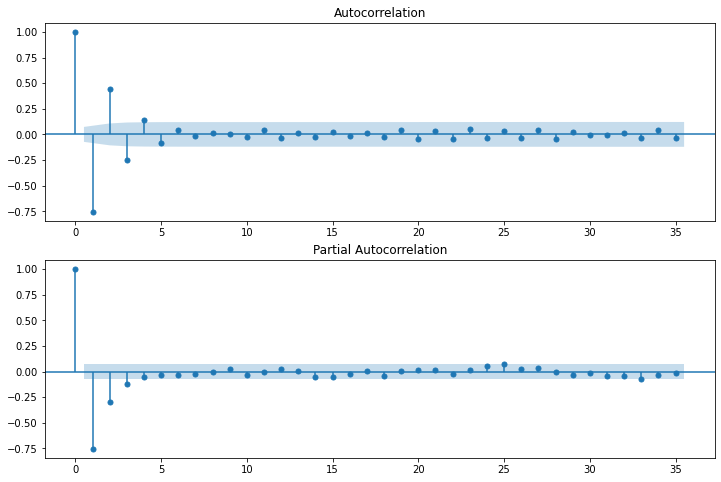

In [34]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(second_diff.values.squeeze(), lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(second_diff, lags=35, ax=ax2)

In [35]:
src_data_model2 = second_ts[:'2023-07-17 00:00:00']

In [36]:
model2 = sm.tsa.ARIMA(src_data_model2.astype(float), order=(2,1,0)).fit()

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  war

In [37]:
print(model2.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  432
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1549.241
Method:                       css-mle   S.D. of innovations              8.724
Date:                Thu, 28 Sep 2023   AIC                           3106.482
Time:                        18:22:19   BIC                           3122.756
Sample:                    06-29-2023   HQIC                          3112.907
                         - 07-17-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8103      0.179      4.529      0.000       0.460       1.161
ar.L1.D.y     -1.0014      0.045    -22.226      0.000      -1.090      -0.913
ar.L2.D.y     -0.3485      0.045     -7.729      0.0

In [38]:
q_test = sm.tsa.stattools.acf(model2.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    1.039702  0.307891
1    4.799510  0.090740
2    5.070551  0.166703
3    7.670654  0.104415
4    8.770768  0.118564
5    8.780870  0.186282
6   10.805151  0.147347
7   12.469301  0.131461
8   12.479757  0.187594
9   13.925298  0.176426
10  14.487702  0.207171
11  15.892730  0.196199
12  18.429863  0.141869
13  19.496071  0.146846
14  23.854157  0.067612
15  23.914283  0.091393
16  25.078030  0.092977
17  25.478176  0.112302
18  28.061802  0.082246
19  28.461601  0.098915
20  28.711359  0.121105
21  28.739202  0.152458
22  30.625266  0.132281
23  31.071750  0.151725
24  31.386635  0.176534
25  34.154342  0.131182
26  34.805269  0.143868
27  36.341571  0.134105
28  36.479879  0.160000
29  36.532875  0.191146
30  36.943163  0.213354
31  37.055748  0.247029
32  37.242588  0.280039
33  38.011587  0.291587
34  38.186909  0.326669
35  38.223845  0.368757
36  40.075442  0.335368
37  40.081327  0.377997
38  42.560692  0.320417
39  43.459710  0.326251


D:\Programs\Anac\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [39]:
pred = model2.predict('2023-07-17 00:00:00','2023-07-29 00:00:00', typ = 'levels')
trn = second_ts['2023-07-17 00:00:00':]
r2 = r2_score(trn, pred)
print ('R^2: %1.2f' % r2)

R^2: 0.84


D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

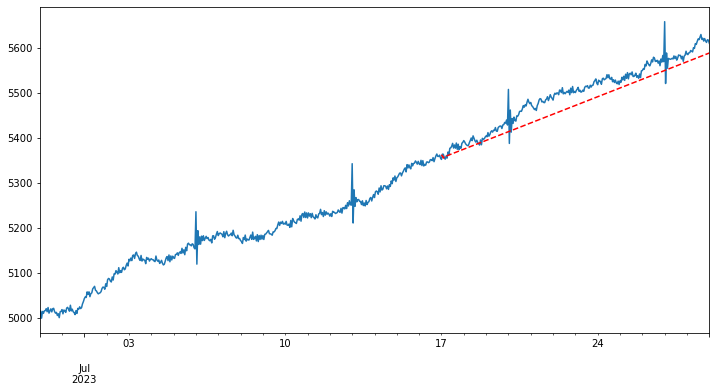

In [40]:
second_ts.plot(figsize=(12,6))
pred.plot(style='r--')

In [41]:
model=sm.tsa.statespace.SARIMAX(src_data_model2.astype(float),order=(2, 1, 1), seasonal_order=(2,1,1,7*24))
results=model.fit()

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observat

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  433
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 168)   Log Likelihood                -967.817
Date:                             Thu, 28 Sep 2023   AIC                           1949.633
Time:                                     18:40:16   BIC                           1974.665
Sample:                                 06-29-2023   HQIC                          1959.692
                                      - 07-17-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4580      0.386     -3.780      0.000      -2.214      -0.702
ar.L2         -0.5274      0.345     -1.528      0.127      -1.204       0.149
ma.L1          0.4513      0.411      1.097      0.273      -0.355       1.258
ar.S.L168      0.2868   4.12e+04   6.97e-06      1.000   -8.07e+04    8.07e+04
ar.S.L336      0.2320   1.35e+04   1.72e-05      1.000   -2.65e+04    2.65e+04
ma.S.L168     -0.6046   4.13e+04  -1.46e-05      1.000    -8.1e+04     8.1e+04
sigma2        82.1488   1.29e+04      0.006      0.995   -2.52e+04    2.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.38   Jarque-Bera (JB):               217.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

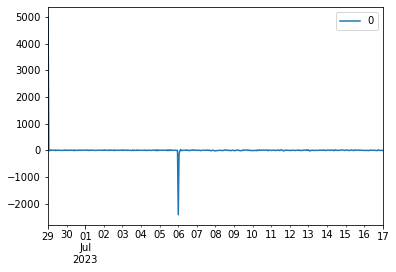

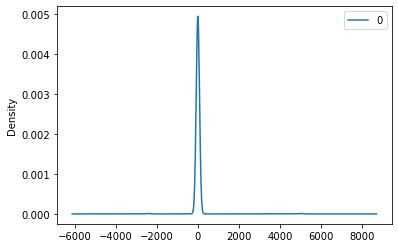

                 0
count   433.000000
mean      5.770465
std     267.348915
min   -2417.549288
25%      -5.587329
50%      -0.002093
75%       5.561795
max    5000.000000


In [43]:
from matplotlib import pyplot
residuals = pd.DataFrame(results.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

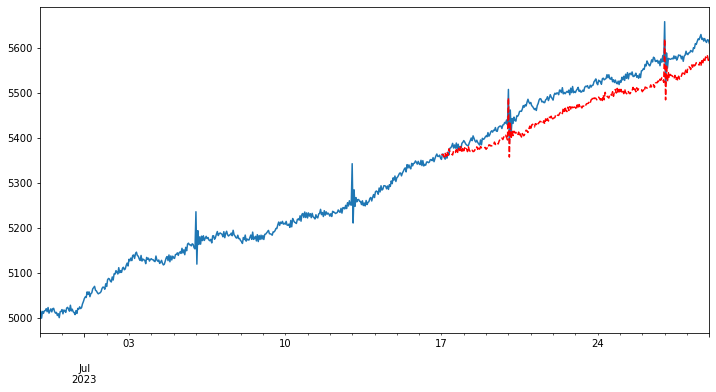

In [44]:
pred=results.predict(start='2023-07-17 00:00:00',end='2023-07-29 00:00:00',dynamic=True)
second_ts.plot(figsize=(12,6))
pred.plot(style='r--')


D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

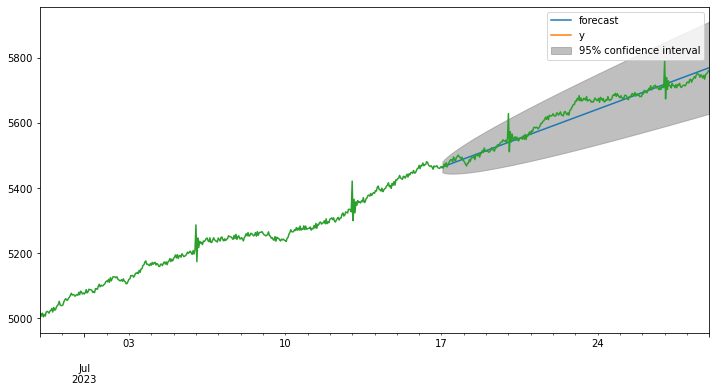

In [39]:
model2.plot_predict(start='2023-07-17 00:00:00',end='2023-07-29 00:00:00',dynamic=True)
second_ts.plot(figsize=(12,6))